In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, make_scorer, f1_score, roc_curve, auc, RocCurveDisplay, roc_auc_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier

In [17]:
df = pd.read_csv('Customer Churn.csv')
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

### Objetivos:
En este trabajo buscaré predecir qué clientes podrían abandonar un servicio (churn) usando técnicas de machine learning. Empezaré con modelos simples e iré mejorando el rendimiento aplicando regresión logística, validación cruzada y creación de nuevas variables. También ajusté el modelo con hiperparámetros. El modelo final logró un F1-score de 0.59 para los casos de churn y un AUC de 0.91, lo que indica una buena capacidad para distinguir entre clientes que se van y los que no.

Enlace al conjunto de datos original: https://archive.ics.uci.edu/dataset/563/iranian+churn+dataset

### Modelo benchmark

Ahora habría que desarrollar un modelo básico y sencillo de comprender a modo de benchmark para compararlo con mejores modelos, pero primero me tomaré la libertad de hacer un pequeño analisis exploratorio de los datos para responder algunas preguntas sobre el dataset.

### ¿Que tipo de información estamos manejando? ¿Están los datos desbalanceados?

In [18]:
# Ver si hay datos faltantes
print(df.isnull().sum())
# Ver si hay datos duplicados
print(df.duplicated().sum())
# Ver si hay datos atípicos
print(df.describe())

call__failure              0
complains                  0
subscription__length       0
charge__amount             0
seconds_of_use             0
frequency_of_use           0
frequency_of_sms           0
distinct_called_numbers    0
age_group                  0
tariff_plan                0
status                     0
age                        0
customer_value             0
churn                      0
dtype: int64
300
       call__failure    complains  subscription__length  charge__amount  \
count    3150.000000  3150.000000           3150.000000     3150.000000   
mean        7.627937     0.076508             32.541905        0.942857   
std         7.263886     0.265851              8.573482        1.521072   
min         0.000000     0.000000              3.000000        0.000000   
25%         1.000000     0.000000             30.000000        0.000000   
50%         6.000000     0.000000             35.000000        0.000000   
75%        12.000000     0.000000             38.000

In [19]:

# Ver la distribución de clases
print(df['churn'].value_counts())
print(df['churn'].value_counts(normalize=True))  # proporciones

churn
0    2655
1     495
Name: count, dtype: int64
churn
0    0.842857
1    0.157143
Name: proportion, dtype: float64


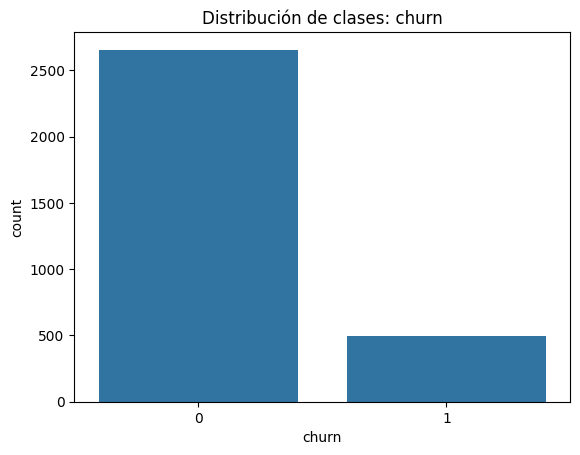

In [20]:
# Visualización de la distribución de clases
sns.countplot(x='churn', data=df)
plt.title("Distribución de clases: churn")
plt.show()

Dado que el 84% de los datos pertenecen a una clase (La clase 0) se considera que el dataset está desbalanceado, lo cuál hay que tener en cuenta durante toda la etapa de preprocesamiento y a la hora de elegir metricas y modelos

Principalmente el Accuracy deja de ser una métrica útil, ya que si el 90% de los datos pertenecen a "No Churn" entonces un modelo que agarre todos los datos y los clasifique como "No Churn" va a tener el 90% de Accuracy.

Las metricas que más nos pueden servir son:

<ul>
<li>Precision</li>
<li>Recall</li>
<li>F1-score</li>
<li>ROC-AUC</li>
<li>Matriz de confusión</li>
</ul>


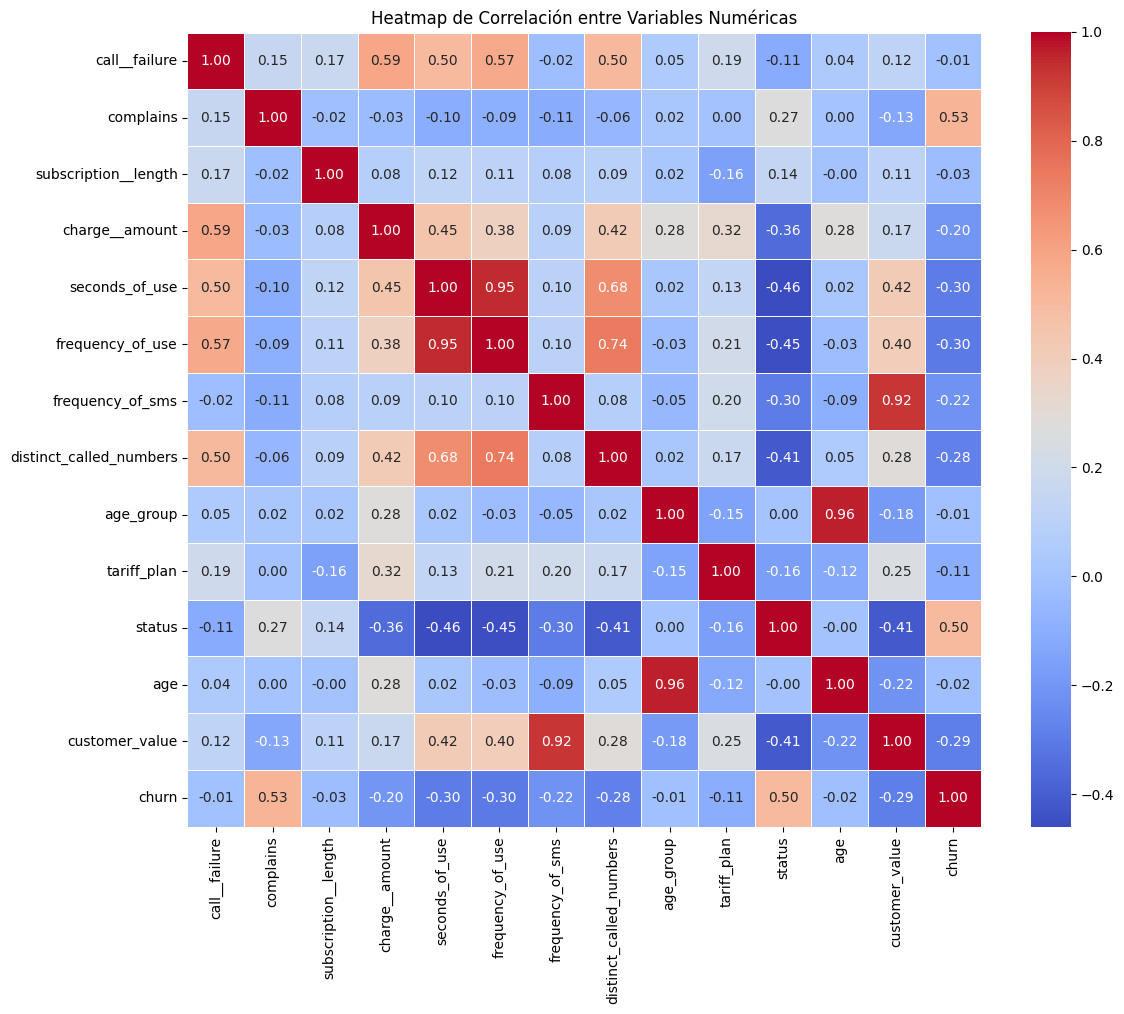

In [21]:
# Seleccionar solo columnas numéricas
df_numeric = df.select_dtypes(include=['float64', 'int64'])

# Calcular la matriz de correlación
corr_matrix = df_numeric.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Heatmap de Correlación entre Variables Numéricas")
plt.tight_layout()
plt.show()

Con esto podemos elegir las variables que nos interesan y que más relacionadas están con Churn, las cuales serían:
<ul>
<li>seconds_of_use</li>
<li>frequency_of_use</li>
<li>complains</li>
<li>charge_amount</li>
<li>tariff_plan</li>
<li>call_failure</li>
<li>customer_value</li>

</ul>


### Benchmark

Como punto de partida, definimos un modelo de referencia simple utilizando un **árbol de decisión (`DecisionTreeClassifier`) con una sola variable**: `complains`. Esta variable fue seleccionada por su alta correlación positiva con la variable objetivo `churn`, y también porque tiene una interpretación clara (indica si un cliente realizó reclamos o no).

Limitamos la profundidad del árbol a 1 para mantener el modelo lo más simple posible, lo que me permite establecer una línea base de rendimiento. Aunque este modelo realiza un aprendizaje básico a partir de los datos, su estructura es mínima y sirve como punto de comparación para evaluar si modelos más complejos, con más atributos y procesamiento, aportan mejoras reales.

A partir de este benchmark, iré comparando el desempeño de los modelos posteriores utilizando métricas apropiadas como F1-score y visualizaciones que me ayuden a entender el comportamiento de cada modelo.



              precision    recall  f1-score   support

           0       0.89      0.98      0.93       783
           1       0.81      0.39      0.53       162

    accuracy                           0.88       945
   macro avg       0.85      0.68      0.73       945
weighted avg       0.87      0.88      0.86       945



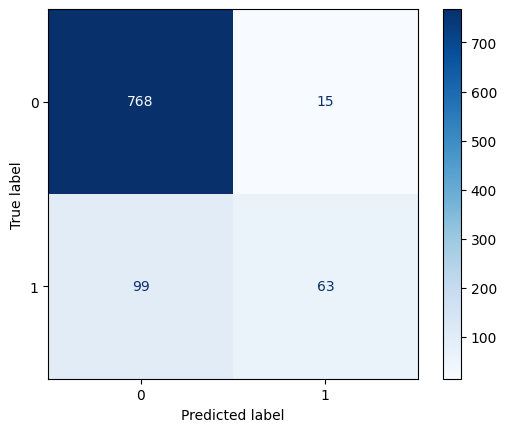

In [22]:
# Usamos solo la variable complains
X = df[['complains']]
y = df['churn']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entrenar árbol de decisión
arbol_simple = DecisionTreeClassifier(max_depth=1, random_state=42)
arbol_simple.fit(X_train, y_train)

# Predicción y evaluación
y_pred_arbol = arbol_simple.predict(X_test)
print(classification_report(y_test, y_pred_arbol))

# Matriz de confusión
ConfusionMatrixDisplay.from_estimator(arbol_simple, X_test, y_test, cmap="Blues")


### Resultados del modelo benchmark

El árbol de decisión entrenado con una sola variable (`complains`) y profundidad máxima 1 alcanzó una **accuracy de 88%**, y un **F1-score de 0.53 para la clase minoritaria (churn)**.

Estos resultados muestran que, incluso con un modelo extremadamente simple, se logra detectar una parte de los clientes que efectivamente abandonan el servicio, aunque también quedan muchos casos sin detectar (99 falsos negativos).

La matriz de confusión muestra que el modelo tiende a predecir correctamente los casos de "no churn", pero tiene dificultades para identificar todos los casos positivos.



### Primer modelo con dos variables

Para construir nuestro primer modelo predictivo, seleccionamos dos atributos: `seconds_of_use` y `complains`. Ambos tienen sentido desde lo lógico, ya que reflejan el nivel de uso del servicio y si el cliente realizó reclamos. Considero que pueden estar relacionados con el riesgo de que un cliente decida cancelar el servicio (*churn*).

La elección de estas variables también se ve respaldada por el análisis de correlación. En el heatmap de correlación, observamos que `complains` tiene una correlación positiva de 0.53 con la variable objetivo (`churn`), lo que indica que las quejas están asociadas a una mayor probabilidad de abandono. Por otro lado, `seconds_of_use` tiene una correlación negativa de -0.30, lo que sugiere que quienes usan menos el servicio tienden a irse.

Como algoritmo utilizaré **regresión logística**, ya que es un modelo simple, interpretativo y apropiado para clasificación binaria.

Dado que las dos variables están en escalas distintas (por ejemplo, `seconds_of_use` tiene valores entre 0 y 17.000, mientras que `complains` es 0 o 1), aplicamos **`StandardScaler`** para normalizarlas. Esto mejora el desempeño de modelos basados en distancias o pesos, como la regresión logística.

Entrenamos el modelo sobre un 70% de los datos, y evaluamos su desempeño sobre el 30% restante. En la siguiente sección, analizaremos sus métricas.


In [23]:
df['seconds_of_use'].describe()

count     3150.000000
mean      4472.459683
std       4197.908687
min          0.000000
25%       1391.250000
50%       2990.000000
75%       6478.250000
max      17090.000000
Name: seconds_of_use, dtype: float64

In [24]:
df['complains'].describe()

count    3150.000000
mean        0.076508
std         0.265851
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: complains, dtype: float64

              precision    recall  f1-score   support

           0       0.89      0.99      0.94       783
           1       0.90      0.39      0.54       162

    accuracy                           0.89       945
   macro avg       0.89      0.69      0.74       945
weighted avg       0.89      0.89      0.87       945



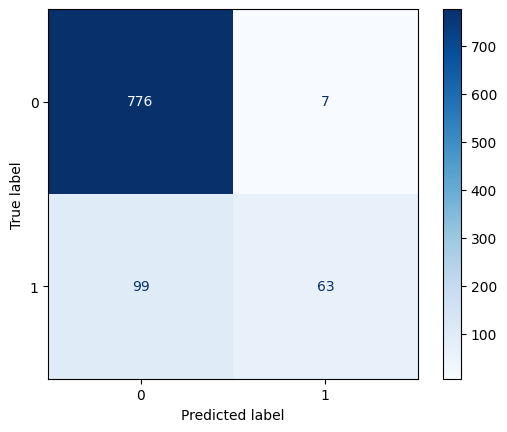

In [25]:
# Elegimos las variables
X = df[['seconds_of_use', 'complains']]
y = df['churn']

# Escalamos las variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Entrenamos el modelo
modelo_2vars = LogisticRegression()
modelo_2vars.fit(X_train, y_train)

# Evaluamos
y_pred = modelo_2vars.predict(X_test)
print(classification_report(y_test, y_pred))

# Matriz de confusión
ConfusionMatrixDisplay.from_estimator(modelo_2vars, X_test, y_test, cmap="Blues")

### Conclusión del modelo con dos variables (comparación con el benchmark)

El modelo con dos variables (`seconds_of_use` y `complains`) muestra una mejora leve respecto al modelo base con una sola variable. El F1-score para la clase churn pasa de 0.53 a 0.54, y se reduce la cantidad de falsos positivos.

### Evaluación del modelo

Para evaluar el desempeño del modelo, dividimos el dataset en un conjunto de entrenamiento (70%) y uno de prueba (30%) utilizando `train_test_split`.

Como métrica principal se utiliza el **F1-score**, ya que combina precisión y recall. Esta métrica es especialmente útil en mi caso debido al desbalance de clases. En este contexto, métricas como accuracy pueden resultar engañosas, ya que un modelo que predice únicamente la clase "no churn" podría mostrar una accuracy alta sin resolver realmente el problema.

Además, complementamos el análisis con la **matriz de confusión**, que permite visualizar cuántos casos fueron correctamente o incorrectamente clasificados en cada clase. Aunque no es una métrica en sí misma, es una herramienta muy útil para interpretar el comportamiento del modelo.



### Frontera de decisión e interpretación

En el siguiente gráfico se muestra la **frontera de decisión** aprendida por el modelo de regresión logística, utilizando las variables `seconds_of_use` y `complains`.

Los puntos representan los datos del conjunto de prueba, y los colores indican la clase real (`0 = no churn`, `1 = churn`). El fondo coloreado señala las zonas donde el modelo predice cada clase.

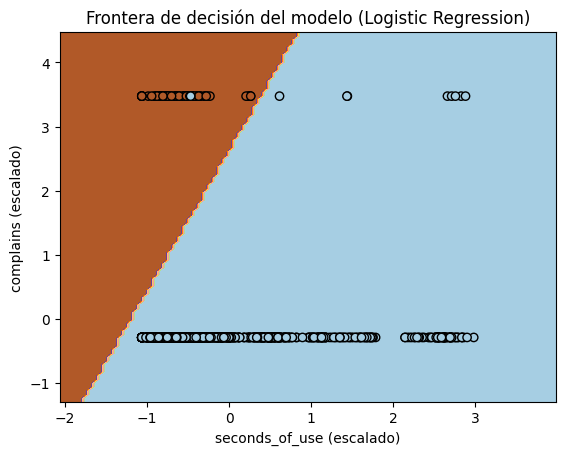

In [26]:
from sklearn.inspection import DecisionBoundaryDisplay
import matplotlib.pyplot as plt

# Graficar la frontera de decisión directamente
disp = DecisionBoundaryDisplay.from_estimator(
    modelo_2vars,
    X_test,
    response_method="predict",
    xlabel="seconds_of_use (escalado)",
    ylabel="complains (escalado)",
    cmap=plt.cm.Paired
)

# Graficar los puntos reales
disp.ax_.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.Paired, edgecolor="k")
disp.ax_.set_title("Frontera de decisión del modelo (Logistic Regression)")
plt.show()

Aunque el gráfico sugiere una frontera bastante clara, la matriz de confusión muestra que hay una cantidad considerable de errores: el modelo no logra detectar correctamente varios casos de churn (99 falsos negativos) y también comete algunos errores sobre la clase mayoritaria (7 falsos positivos).

Esto se refleja en los valores obtenidos de recall y F1-score para la clase churn, que si bien son "mejores" que el modelo base, aún dejan margen para mejorar.


### Segundo modelo: Random Forest con múltiples atributos
Como segundo modelo se utilizó un **Random Forest**, que es un conjunto de árboles de decisión
entrenados sobre diferentes subconjuntos del dataset. Este tipo de modelo es útil cuando hay
relaciones no lineales entre las variables y permite mejorar la capacidad predictiva sin necesidad
de mucho preprocesamiento .
A diferencia de otros modelos, **no requiere escalar las variables**, lo que simplifica el proceso.
Se seleccionaron las siguientes variables, por su relevancia para el problema de churn:

- `seconds_of_use`
- `complains`
- `frecuency_of_use`
- `status`
- `customer_value`
- `distinct_called_number`

Este modelo será evaluado con métricas de clasificación y validación cruzada, y se analizará la
importancia de los atributos.

Evaluación del modelo Random Forest:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       783
           1       0.82      0.71      0.76       162

    accuracy                           0.92       945
   macro avg       0.88      0.84      0.86       945
weighted avg       0.92      0.92      0.92       945



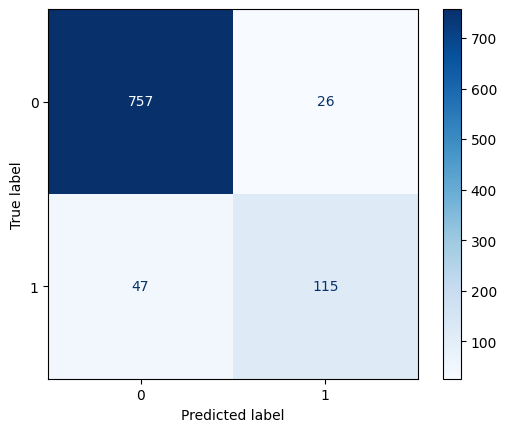

In [27]:
# Variables seleccionadas
features = [
 'complains',
 'status',
 'seconds_of_use',
 'frequency_of_use',
 'customer_value',
 'distinct_called_numbers'
]
X = df[features]
y = df['churn']
# División de datos
X_train, X_test, y_train, y_test = train_test_split(X, y,
test_size=0.3, random_state=42)
# Entrenamiento del modelo
rf_model = RandomForestClassifier(class_weight='balanced',
random_state=42)
rf_model.fit(X_train, y_train)
# Evaluación
y_pred = rf_model.predict(X_test)
print("Evaluación del modelo Random Forest:")
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test,
cmap="Blues")

### Evaluación del modelo Random Forest
El modelo Random Forest se entrenó utilizando las 6 variables con mayor correlación con
churn, aplicando además el parámetro `class_weight='balanced'` para manejar el
desbalance de clases. Esta configuración permite al modelo enfocarse en la detección de la clase
minoritaria sin afectar significativamente el rendimiento general.
Las métricas obtenidas sobre el conjunto de prueba fueron:
- **F1-score para clase churn**: 0.76
- **Precision**: 0.82
- **Recall**: 0.71
- **Accuracy total**: 0.92
La matriz de confusión muestra que el modelo identificó correctamente **115 de los 162 casos de churn**, con solo 26 falsos positivos.

### Evaluación con validación cruzada

Para tener una evaluación más robusta del modelo, se aplicó **validación cruzada estratificada** con 5 folds (`StratifiedKFold`), lo que permite estimar el desempeño del modelo en distintos subconjuntos de los datos, manteniendo la proporción de clases. Se calculó el **F1-score para la clase churn (1)** en cada iteración, y luego se promediaron los resultados.


In [28]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scorer = make_scorer(f1_score, pos_label=1)
cv_scores = cross_val_score(rf_model, X, y, scoring=f1_scorer, cv=cv)
# Mostrar resultados redondeados
print("F1 por fold:", [f"{s:.2f}" for s in cv_scores])
print("F1 promedio:", round(cv_scores.mean(), 2))
print("Desviación estándar:", round(cv_scores.std(), 2))

F1 por fold: ['0.76', '0.77', '0.77', '0.79', '0.80']
F1 promedio: 0.78
Desviación estándar: 0.01


Esta técnica consiste en dividir el conjunto de datos en cinco partes, entrenar el modelo cinco veces utilizando una partición diferente como conjunto de prueba en cada iteración, y promediar los resultados.

Esto permite evaluar qué tan estable es el modelo frente a diferentes subconjuntos de datos, reduciendo la dependencia de una sola división train/test.

Los valores obtenidos para el **F1-score de la clase churn (1)** en cada fold fueron:

- Fold 1: 0.76  
- Fold 2: 0.77  
- Fold 3: 0.77  
- Fold 4: 0.79  
- Fold 5: 0.80  

El **F1-score promedio fue de 0.78**, con una **desviación estándar de 0.01**.

### Importancia de los atributos en el segundo modelo
Al ser un Random Forest, es posible analizar la importancia de cada atributo a partir de cuánto contribuye a reducir la impureza en los árboles (medida Gini).
A continuación se muestra el gráfico de importancia de los atributos utilizados:
- **status** fue la variable más influyente, con una importancia cercana al 20%. Esto indica
que el estado del cliente (activo/inactivo) es un fuerte indicador de su probabilidad de
churn.
- **seconds_of_use** y **customer_value** también fueron altamente relevantes, lo que sugiere
que el nivel de uso y el valor del cliente están relacionados con su permanencia.
- **frequency_of_use** y **complains** aportan información adicional clave, aunque con algo
menos de peso.
- Por último, **distinct_called_numbers** tuvo menor importancia relativa, pero igualmente
contribuyó al modelo.

La siguiente imagen nos permite interpretar qué variables tienen mayor peso en la decisión del
modelo, lo cual es valioso para entender el comportamiento del cliente y tomar decisiones de
negocio más informadas/justificadas.


C:\Users\joaco\AppData\Local\Temp\ipykernel_9364\3544592135.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importancia", y="Variable", data=importancia_df,


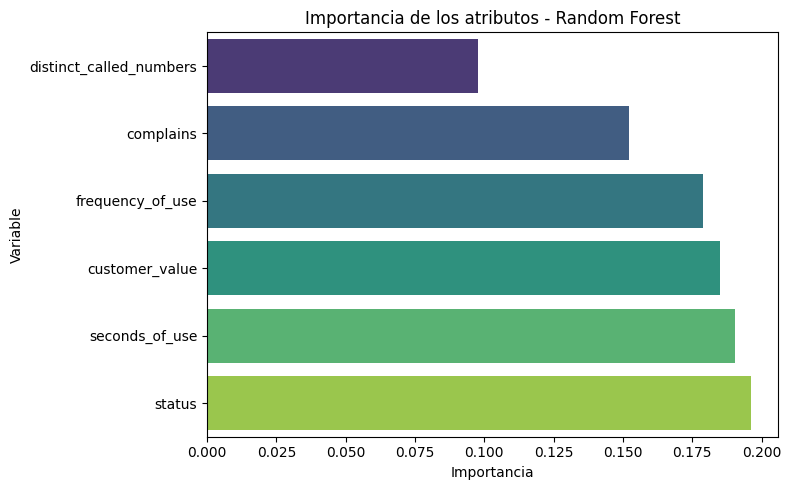

In [29]:
# Importancia de los atributos
importancias = rf_model.feature_importances_
importancia_df = pd.DataFrame({'Variable': X.columns, 'Importancia':
importancias})
importancia_df = importancia_df.sort_values(by="Importancia",
ascending=True)
# Gráfico
plt.figure(figsize=(8,5))
sns.barplot(x="Importancia", y="Variable", data=importancia_df,
palette="viridis")
plt.title("Importancia de los atributos - Random Forest")
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()

### Comparación de modelos y elección final

A lo largo del trabajo se evaluaron diferentes modelos con el objetivo de predecir churn de forma efectiva:

1. **Modelo benchmark (árbol de decisión con una sola variable)**  
   - Utilizó únicamente la variable `complains`.  
   - F1-score para churn: **0.53**  
   - Se usó como referencia mínima de desempeño.

2. **Modelo base (regresión logística con dos variables)**  
   - Variables: `seconds_of_use` y `complains`  
   - F1-score para churn: **0.54**  
   - Apenas superó al benchmark, pero fue útil como punto de partida.

3. **Modelo final (Random Forest con class_weight='balanced')**  
   - F1-score (clase churn): 0.76
   - Validación cruzada
   - - F1 promedio: 0.78
   - - Desviación estándar: 0.01


### Elección del modelo para uso operativo

El **Random Forest** balanceado es el modelo más adecuado para un uso real, ya que combina:
- **Alto rendimiento** en detección de churn,
- **Estabilidad** en múltiples particiones del dataset,
- Y posibilidad de interpretar la importancia relativa de las variables.
Esto lo convierte en la mejor opción para llevar a producción.


### ¿Cómo se podría continuar el trabajo?
Para mejorar el modelo y su utilidad práctica, se podrían realizar las siguientes acciones en el
futuro:
- **Explorar otros algoritmos** como XGBoost, que suele tener mejor rendimiento en
problemas de clasificación.
- **Ajustar el umbral de decisión**, buscando un mejor equilibrio entre precisión y recall,
especialmente si el objetivo es maximizar la detección de churn.
- **Probar técnicas de remuestreo** como SMOTE o submuestreo de la clase mayoritaria
para comparar con el uso de class_weight='balanced'.
- **Crear nuevas variables** combinando información de uso y reclamos, lo que podría
aportar más valor predictivo.
- **Evaluar el modelo en un entorno más cercano a producción**, por ejemplo con nuevos
datos simulados o recientes, para analizar su desempeño fuera del dataset original.